# Set up environment

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import os
from matplotlib import pyplot as plt
import numpy as np

## Enable GPU



In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


## Declare parameters

In [5]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))

INPUT_SIZE = 299
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 0.001

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
loss_func = "binary_crossentropy"

# Input data

## Download 'non-food' dataset

I will use a downsampled ImageNet dataset for the 'non-food' images since it's free to access and has the broadest variety of images. However the images are limited to a resolution of 64x64 and they aren't labelled, so the 51 food classes will be treated as 'non-food'.

In [ ]:
non_food_train_raw = tfds.load("downsampled_imagenet/64x64", split="train")
non_food_val_raw = tfds.load("downsampled_imagenet/64x64", split="validation")

## Download 'food' dataset

I will the Food-101 dataset for the 'food' images, manually splitting with a 8:2 ratio of training to validation images.

In [5]:
food_train_raw = tfds.load("food101", split="train[:80]")
food_val_raw = tfds.load("food101", split="train[80:]")

## Reduce datasets

As this is only a binary classification, it is unnecessary to use the full datasets and we also need to ensure there are the same number of 'non-food' images as food images.

In [6]:
TRAINING_SIZE = 100000
VAL_SIZE = 10000

food_train_raw = food_train_raw.shuffle(SHUFFLE_BUFFER_SIZE).take(TRAINING_SIZE//2)
non_food_train_raw = non_food_train_raw.shuffle(SHUFFLE_BUFFER_SIZE).take(TRAINING_SIZE//2)
food_val_raw = food_val_raw.shuffle(SHUFFLE_BUFFER_SIZE).take(VAL_SIZE//2)
non_food_val_raw = non_food_val_raw.shuffle(SHUFFLE_BUFFER_SIZE).take(VAL_SIZE//2)

## Format and label the images

Next, I will format the images for input into a convolutional neural network by rescaling the values between 0 & 1 and resizing to model input size. I will also label the data by labelling food images 1 and non-food images 0.

In [15]:
def formatImage(img):
  img = tf.cast(img, tf.float32)
  img /= 255
  img = tf.image.resize_with_pad(img, INPUT_SIZE, INPUT_SIZE)
  return img

def formatNonFood(features):
  img = features["image"]
  img = formatImage(img)
  return img, 0

def formatFood(features):
  img = features["image"]
  img = formatImage(img)
  return img, 1

food_train_raw = food_train_raw.map(formatFood)
food_val_raw = food_val_raw.map(formatFood)
non_food_train_raw = non_food_train_raw.map(formatNonFood)
non_food_val_raw = non_food_val_raw.map(formatNonFood)

tf.Tensor(
[[[0.849908   0.88217986 0.82335633]
  [0.8403621  0.8841144  0.8293856 ]
  [0.82827294 0.87950045 0.8374015 ]
  ...
  [0.98590523 0.97872645 0.9969004 ]
  [0.96428895 0.97742546 0.9932075 ]
  [0.95456666 0.98400456 0.99351346]]

 [[0.85624635 0.871126   0.8122251 ]
  [0.8724335  0.89542514 0.8407736 ]
  [0.87290305 0.90932506 0.8703258 ]
  ...
  [0.97330946 0.9297393  0.95258635]
  [0.9777044  0.954369   0.97063   ]
  [0.9741622  0.96841097 0.9809824 ]]

 [[0.88398796 0.8756595  0.81046396]
  [0.8897761  0.88611704 0.8283625 ]
  [0.87966686 0.889899   0.84007215]
  ...
  [0.9402032  0.8323823  0.86375475]
  [0.97264737 0.8763261  0.90286565]
  [0.9838284  0.90005666 0.92605853]]

 ...

 [[0.890898   0.62594944 0.05474484]
  [0.90825    0.64942646 0.0768774 ]
  [0.91689706 0.65807354 0.08552451]
  ...
  [0.76250786 0.6087049  0.32654014]
  [0.7360681  0.58704853 0.30249214]
  [0.7501692  0.6011496  0.31659317]]

 [[0.8754646  0.6166411  0.03624889]
  [0.8863114  0.6274879  0

## Merge datasets

Concatenate the food and 'non-food' datsets.

In [8]:
train_raw = food_train_raw.concatenate(non_food_train_raw)
val_raw = food_val_raw.concatenate(non_food_val_raw)

## Prepare dataset

Shuffle and batch the images ready for training on the model.

In [9]:
train_batches = train_raw.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
val_batches = val_raw.batch(BATCH_SIZE, drop_remainder=True) 

## Show example images

Randomly select and display 20 images from the dataset along with their class (i.e. food or 'non-food').

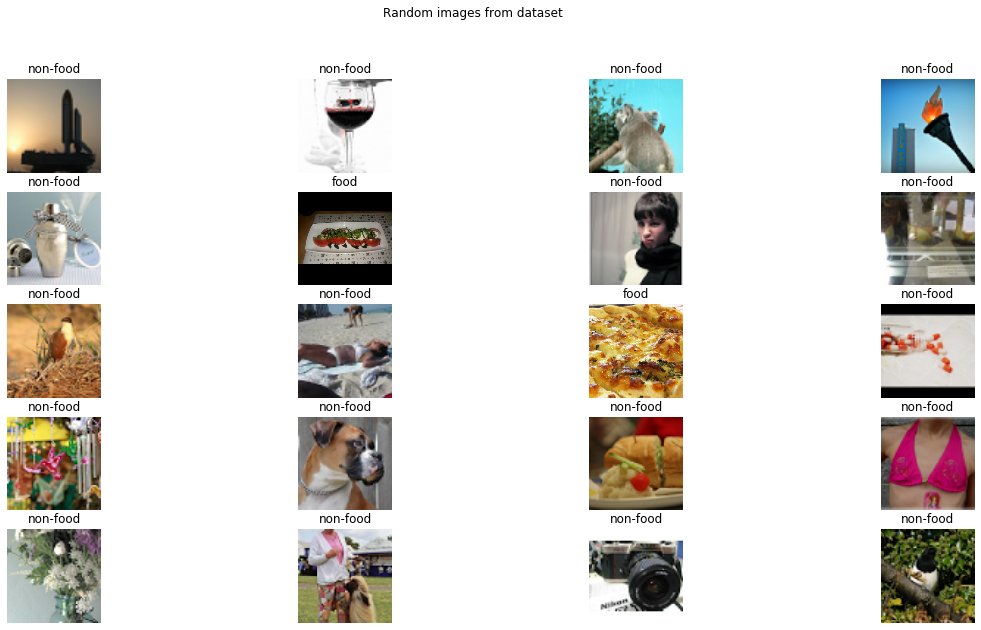

In [10]:
cols, rows = 4, 5
fig = plt.figure(figsize=(20,10))
fig.suptitle("Random images from dataset")

examples = train_batches.unbatch().batch(20).as_numpy_iterator()

images, labels = next(examples)

for i in range(1, cols*rows+1):
  fig.add_subplot(rows, cols, i)

  img = images[i-1]

  if labels[i-1] == 1:
    plt.title("food")
  else:
    plt.title("non-food")

  plt.axis("off")
  plt.imshow(img, interpolation="nearest")
plt.show()

# Model

In order to train a binary classifier we take a pretrainied Inception model on the ImageNet dataset and replace the classification head with a single logistic node.

In [11]:
base_model = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4", output_shape=[2048], trainable=False)

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build([None, INPUT_SIZE, INPUT_SIZE, 3])

model.compile(optimizer=optimizer, loss=loss_func, metrics=["accuracy"])

model.summary()

KeyboardInterrupt: 

# Training via transfer learning

## Train the classification head

I now train the classification head of the model on the dataset as the feature extractor part of the model has been frozen.

In [ ]:
history = model.fit(train_batches, validation_data=val_batches, epochs=EPOCHS)

## Save model weights

In [ ]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "binary_classification", "inception_v3", "transfer_learning.h5")
model.save(MODEL_PATH, overwrite=True)

## Evaluate transfer learning

In [7]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(True)
plt.legend(loc='lower right')

NameError: name 'history' is not defined